## BASICS

We will now try to build a model that is able to predict whether an enrollee is open for a job change or not. We already know that the dataset is imbalanced: only ~25% of the observations belong to the *positive* class (= open for job change). 

Models trained on imbalanced datasets may become biased towards the majority class since there is more information available for this class. As a result, the model may struggle to accurately classify instances from the minority class.

Accuracy is a commonly used metric for evaluating classification models, but it can be misleading in imbalanced datasets. A model that predicts the majority class for every instance may achieve high accuracy, but it would not be useful in practice, especially if the goal is to correctly classify instances from the minority class.
Therefore, my goal will not be to optimize this metric.

Which metric would be more appropriate? 
Suppose this company wants to make a job offer to some of the course enrollees. However, every job offer is preceded by a closer examination of skills and also a few interviews. This process is complex and therefore expensive. The company only wants to invest this effort in enrollees who it is convinced are really willing to change their job.

In such a case, precision is the evaluation metric of choice. It indicates how accurately we predict the positive class (willing to change). It may produce some false negatives, but we can be relatively confident that the positive ones are correctly predicted.
So we try to improve the precision, but keep an eye on the other metrics.

Let's do it!

In [1]:
# import packages

import pandas as pd
import numpy as np
import matplotlib as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler, NearMiss, TomekLinks
from sklearn.metrics import classification_report, accuracy_score,confusion_matrix, precision_score

# suppress warnings
import warnings
warnings.filterwarnings('ignore')

RSEED = 15

In [2]:
# load the data
HR = pd.read_csv('data/aug_train.csv')

Based on my knowledge about the data (from the EDA) I decide to fill all NaNs in the dataset with 'MISSING'. 

I do this for the following reasons:

In some cases, the fact that the data is missing probably has a meaning: if major_discipline is missing, it is (usually) because the enrollee did or does not study. If company_size and company_type are missing, it is (probably in many cases) because the enrollee is not currently employed. If these connections exist, the model will probably recognize them at least partially. It would be fatal to simply delete the data or to impute it without further evidence with any assumptions that go beyond the simple realization of "MISSING".

In other cases, I have found no evidence that the fact that data is missing could mean something specific: e.g. in the case of gender. But I don't want to simply delete almost a quarter of my observations. Imputation with “MISSING” seems to me to be the most sensible solution here too.

In [3]:
# impute all NaNs in the dataset with 'MISSING'
HR = HR.fillna('MISSING')

Now I separate the features from the target variable:

In [4]:
#Separate training features from target
X = HR.drop(['target'], axis=1)
y = HR['target']

Now it's time for the train test split. Since we are dealing with an imbalanced dataset, stratified train test split is the way to go. (It'll ensure that the distribution of target classes in the training and testing sets remains similar to the original dataset.)

In [5]:
# stratified train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [6]:
y_train.value_counts()

target
0.0    11504
1.0     3822
Name: count, dtype: int64

## Baseline Model

Now we build the baseline model. It's a simple Logistic Regression. The result is our benchmark which we want to improve. We use a pipeline here.

In [7]:
# create a list of categorical features
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# create a list of numerival features
numeric_features = X.select_dtypes(exclude=['object']).columns.tolist()

# include a step to scale the numerical
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# include a step to encode the categorical
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# create a column transformer, that combines both steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

In [8]:
# define the model
bl_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=RSEED))
])

# fit the model
bl_model.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['enrollee_id',
                                                   'city_development_index',
                                                   'training_hours']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['city', 'gender',
                                                   'relevent_experience',
                                                   'enrolled_university',
                                                   'education_level',
                                                   'major_discipline',
                                                   'experience', 'company_size',
                                                   'company_type',
                                                   'last_new_job'])])),
                ('classifier', LogisticRegression(random_state=15))])

In [9]:
# make predictions on the test data
y_pred_bl = bl_model.predict(X_test)

In [10]:
#show results 
print("Accuracy:", accuracy_score(y_test, y_pred_bl).round(2))
print("Classification Report:\n", classification_report(y_test, y_pred_bl))

Accuracy: 0.78
Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.91      0.86      2877
         1.0       0.60      0.39      0.47       955

    accuracy                           0.78      3832
   macro avg       0.71      0.65      0.67      3832
weighted avg       0.76      0.78      0.77      3832



We are particularly interested in the precesion on target 1.0! What does a precision of 0.60 mean?

It means that (in our case: only) 60% of the positive predictions are actually positive! 

That's not a very good result. What does it all look like exactly? Let's take a look at a confusion matrix:

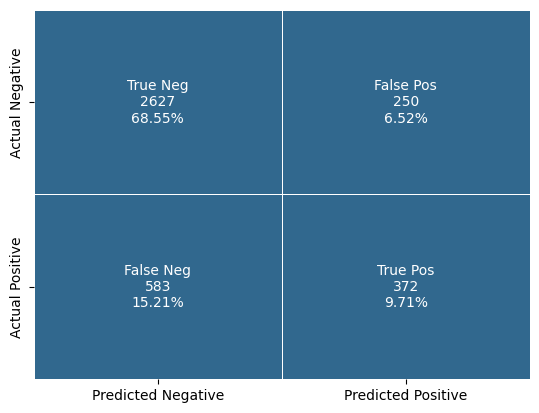

In [11]:
cfm_bl = confusion_matrix(y_test, y_pred_bl)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                cfm_bl.flatten()]
group_percentages = ['{0:.2%}'.format(value) for value in
                     cfm_bl.flatten()/np.sum(cfm_bl)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cfm_bl, annot=labels, fmt='', cmap = ['#31688e'], cbar=False, xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'], linewidths=0.5, linecolor='white');

So the model found a total of 622 enrollees who it believes are willing to change jobs. But that actually only applies to 372 of them. 250 of these supposedly willing to change jobs don't want to change jobs at all.
On the other hand, 583 of those who want to change their job are not recognized. (These do not play a role in calculating the precision score, but of course this number should also go down as the model improves!)

A first step towards improvement can be to correct the imbalance in the data set. We'll try that now.

## Model

I try different models and oversampling techniques to see what's most promising.

In [12]:
# models I want to test
classifiers = [
    RandomForestClassifier(random_state=RSEED),
    LogisticRegression(random_state=RSEED),
    DecisionTreeClassifier(random_state=RSEED),
    KNeighborsClassifier()]

First I check the performance per model without any oversampling.

In [13]:
for classifier in classifiers:
    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
    ])
    model = pipeline.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(classifier.__class__.__name__, "WITHOUT OVERSAMPLING")
    print("Accuracy:", accuracy_score(y_test, y_pred).round(2))
    print("Precision:", precision_score(y_test, y_pred).round(2))

RandomForestClassifier WITHOUT OVERSAMPLING
Accuracy: 0.78
Precision: 0.58
LogisticRegression WITHOUT OVERSAMPLING
Accuracy: 0.78
Precision: 0.6
DecisionTreeClassifier WITHOUT OVERSAMPLING
Accuracy: 0.74
Precision: 0.48
KNeighborsClassifier WITHOUT OVERSAMPLING
Accuracy: 0.76
Precision: 0.52


Our logistic regression from the baseline model performs best.

At this point I have tried out different over/undersampling techniques with the following code:

```
sampling_methods = [
    ('RandomUnderSampler', RandomUnderSampler(random_state=RSEED)),
    ('TomekLinks', TomekLinks(sampling_strategy='auto')),
    ('NearMiss', NearMiss(version=2)),
    ('RandomOverSampler', RandomOverSampler(random_state=RSEED)),
    ('ADASYN', ADASYN(random_state=RSEED)),
    ('SMOTE', SMOTE(random_state=RSEED))
]

results_list = []

for classifier in classifiers:
    for method_name, sampler in sampling_methods:
        
        pipeline = Pipeline(steps=[
            ('preprocessor', preprocessor),
            (method_name, sampler),
            ('classifier', classifier)
        ])

        
        model = pipeline.fit(X_train, y_train)

        
        y_pred = model.predict(X_test)

        
        accuracy = accuracy_score(y_test, y_pred).round(2)
        precision = precision_score(y_test, y_pred).round(2)

        
        results_list.append({
            'Classifier': classifier.__class__.__name__,
            'Sampling Method': method_name,
            'Accuracy Score': accuracy,
            'Precision Score': precision
        })


results_df = pd.DataFrame(results_list)
results_df.to_csv('data/results.csv', index=False)

```

I've saved the results in a csv file and load it from there now as it takes too long to run the code block each time I restart the Kernel in this notebook.
Now let's have a look at the perfomance metrics. I sort the results by Precision Score, highest first.

In [22]:
results = pd.read_csv('data/results.csv')
results.sort_values(by='Precision Score', ascending =False)

,Classifier,Sampling Method,Accuracy Score,Precision Score
7,LogisticRegression,TomekLinks,0.80,0.60
4,RandomForestClassifier,ADASYN,0.79,0.58
1,RandomForestClassifier,TomekLinks,0.79,0.57
3,RandomForestClassifier,RandomOverSampler,0.79,0.57
5,RandomForestClassifier,SMOTE,0.79,0.57
0,RandomForestClassifier,RandomUnderSampler,0.77,0.53
9,LogisticRegression,RandomOverSampler,0.77,0.53
11,LogisticRegression,SMOTE,0.78,0.53
10,LogisticRegression,ADASYN,0.76,0.52
19,KNeighborsClassifier,TomekLinks,0.76,0.52


The best results we get from a Logistic Regression, that uses TomekLinks for undersampling. It has the same precision as our baseline model (also Logistic Regression), but a better accuracy.

I was actually hoping that we could improve the performance of the model even more with sampling. I'll try to improve the performance of the Logistic Regression and the Random Forest Classifier with hyperparameter tuning and feature selection.